In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

import tqdm
from tqdm.auto import tqdm;

d:\Cinthia\env_modelos\venv2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#SOLO EJECUTAR UNA VEZ POR DIA
INTENTO=1

In [3]:
# Make a device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
#GPUS
n_gpus = torch.cuda.device_count()
print(f"Number of gpus: {n_gpus}")

Number of gpus: 1


In [5]:
class ConvBlock (nn.Module):
    def __init__(self,
                in_channels: int,
                out_channels: int,
                 **kwargs): # this means that the key arguments are arbitrary
        super().__init__()

        self.relu = nn.ReLU()
        self.conv = nn.Conv2d(in_channels=in_channels,
                            out_channels=out_channels,
                              **kwargs,
                            device=device)
        self.batchnorm = nn.BatchNorm2d(num_features=out_channels) # to improve performance
    
    def forward(self,x):
        x = self.conv(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        return x

In [6]:
class L2NormLayer(nn.Module):
    def __init__(self,dim=1):
        super().__init__()
        self.dim=dim
    
    def forward(self,x):
        return nn.functional.normalize(x,p=2,dim=self.dim)

In [7]:
class InceptionBlock (nn.Module):
        def __init__(self,
                in_channels: int,
                out_1x1: int,

                red_3x3: int,
                out_3x3: int,

                red_5x5: int,
                out_5x5: int,

                out_1x1pool: int,
                
                l2_mode:bool=False):
        
                super().__init__()

                self.branch1 = ConvBlock(in_channels=in_channels,
                                        out_channels=out_1x1,
                                        kernel_size=1)
                
                self.branch2 = nn.Sequential(
                        ConvBlock(in_channels=in_channels,
                                out_channels=red_3x3,
                                kernel_size=1),
                        ConvBlock(in_channels=red_3x3,
                                out_channels=out_3x3,
                                kernel_size=3,
                                padding=1) 
                )
                
                self.branch3 = nn.Sequential(
                        ConvBlock(in_channels=in_channels,
                                out_channels=red_5x5,
                                kernel_size=1),
                        ConvBlock(in_channels=red_5x5,
                                out_channels=out_5x5,
                                kernel_size=5,
                                padding=2)
                )

                if l2_mode:
                        self.branch4=nn.Sequential(
                                L2NormLayer(dim=1),
                                ConvBlock(in_channels=in_channels,
                                out_channels=out_1x1pool,
                                kernel_size=1)
                        )
                else:
                        self.branch4 = nn.Sequential(
                                nn.MaxPool2d(kernel_size=3,stride=1,padding=1),
                                ConvBlock(in_channels=in_channels,
                                        out_channels=out_1x1pool,
                                        kernel_size=1)
                        )

        def forward(self,x):
        # N x filters x 28 x 28 → 0th x 1st x 2nd x 3rd dimension (we use 1)
                return torch.cat([self.branch1(x),self.branch2(x),self.branch3(x),self.branch4(x)],1)

In [8]:
class InceptionBlock_2(nn.Module):
    def __init__(self, 
                in_channels:int, 
                red_3x3:int,
                out_3x3:int) -> None:
        super().__init__()
        self.branch=nn.Sequential(
            ConvBlock(in_channels=in_channels,
                    out_channels=red_3x3,
                    kernel_size=1),
            ConvBlock(in_channels=red_3x3,
                    out_channels=out_3x3,
                    kernel_size=3)
        )
    def forward(self,x):
        return self.branch(x)

In [9]:
class InceptionBlock_m_3x3 (nn.Module):
        def __init__(self,
                in_channels: int,

                red_3x3: int,
                out_3x3: int,

                red_5x5: int,
                out_5x5: int):
        
                super().__init__()

                self.branch2 = nn.Sequential(
                        ConvBlock(in_channels=in_channels,
                                out_channels=red_3x3,
                                kernel_size=1),
                        ConvBlock(in_channels=red_3x3,
                                out_channels=out_3x3,
                                kernel_size=3,
                                padding=1,
                                stride=2) # ojo (btw no ponemos el S bc por defecto es 1)
                )
                
                self.branch3 = nn.Sequential(
                        ConvBlock(in_channels=in_channels,
                                out_channels=red_5x5,
                                kernel_size=1),
                        ConvBlock(in_channels=red_5x5,
                                out_channels=out_5x5,
                                kernel_size=5,
                                padding=2,
                                stride=2) # ojo (btw no ponemos el S bc por defecto es 1)
                )

                self.branch4 = nn.Sequential(
                        nn.MaxPool2d(kernel_size=3,stride=2,padding=1), 
                )

        def forward(self,x):
        # N x filters x 28 x 28 → 0th x 1st x 2nd x 3rd dimension (we use 1)
                return torch.cat([self.branch2(x),self.branch3(x),self.branch4(x)],1)

## Structure of the Model

In [10]:
class NN2 (nn.Module):
    def __init__(self,
                in_channels = 3):
        super().__init__()

        self.conv1 = ConvBlock(in_channels=in_channels,
                            out_channels=64,
                            kernel_size=7,
                            stride=2,
                            padding=3)
        
        self.inception2 = InceptionBlock_2(in_channels=64,
                                        red_3x3=64,
                                        out_3x3=192)
    
        self.inception3a = InceptionBlock( in_channels= 192, out_1x1= 64, red_3x3= 96, out_3x3= 128, red_5x5= 16,out_5x5= 32, out_1x1pool= 32)#ok
        self.inception3b = InceptionBlock( in_channels= 256, out_1x1= 64, red_3x3= 96, out_3x3= 128, red_5x5= 32,out_5x5= 64, out_1x1pool= 64,l2_mode=True)
        #modificar desactivando branch 1 y 4
        self.inception3c = InceptionBlock_m_3x3( in_channels= 320, red_3x3= 128, out_3x3= 256, red_5x5= 32,out_5x5= 64)
        
        self.inception4a = InceptionBlock( in_channels= 640, out_1x1= 256, red_3x3= 96, out_3x3= 192, red_5x5= 32,out_5x5= 64, out_1x1pool= 128,l2_mode=True)
        self.inception4b = InceptionBlock( in_channels= 640, out_1x1= 224, red_3x3= 112, out_3x3= 224, red_5x5= 32,out_5x5= 64, out_1x1pool= 128,l2_mode=True)
        self.inception4c = InceptionBlock( in_channels= 640, out_1x1= 192, red_3x3= 128, out_3x3= 256, red_5x5= 32,out_5x5= 64, out_1x1pool= 128,l2_mode=True)
        self.inception4d = InceptionBlock( in_channels= 640, out_1x1= 160, red_3x3= 144, out_3x3= 288, red_5x5= 32,out_5x5= 64, out_1x1pool= 128,l2_mode=True)
        #modificar desactivando branch 1 y 4
        self.inception4e = InceptionBlock_m_3x3( in_channels= 640, red_3x3= 160, out_3x3= 256, red_5x5= 64,out_5x5= 128)
        
        self.inception5a = InceptionBlock( in_channels= 1024, out_1x1= 384, red_3x3= 192, out_3x3= 384, red_5x5= 48,out_5x5= 128, out_1x1pool= 128,l2_mode=True)
        self.inception5b = InceptionBlock( in_channels= 1024, out_1x1= 384, red_3x3= 192, out_3x3= 384, red_5x5= 48,out_5x5= 128, out_1x1pool= 128)#ok
        
        self.maxpool = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)

        self.avgpool = nn.AvgPool2d(kernel_size=7)
        
        self.FC = nn.Linear(1024,128)

        self.norm=nn.BatchNorm2d(num_features=64)


    def forward(self,x):
        x = self.conv1(x)
        x = self.maxpool(x)

        x=self.norm(x)

        x = self.inception2(x)
        x = self.maxpool(x)

        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.inception3c(x)

        x = self.inception4a(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        x = self.inception4e(x)

        x = self.inception5a(x)
        x = self.inception5b(x)
        x = self.avgpool(x)

        x=x.view(x.shape[0],-1)

        x = self.FC(x)
        x = nn.functional.normalize(x,p=2,dim=1)

        return x

## Transform

In [11]:
transform=transforms.Compose([
    transforms.Resize((224,224)),  #Para pasar a 224 x 224 pixels
    transforms.ToTensor()          #Para convertir la imagen a tensor
])

transform_augmented=transforms.Compose([
    transforms.Resize((224,224)),  #Para pasar a 224 x 224 pixels
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor()          #Para convertir la imagen a tensor
])


## Path of dataset

In [12]:
import os

print(os.getcwd())

d:\Cinthia\env_modelos


In [13]:
from pathlib import Path

root_data_path=Path('data_2000')
train_path=root_data_path / 'train'

test_path=root_data_path / 'test'

train_path

WindowsPath('data_2000/train')

In [14]:
img_path_list=list(test_path.glob('*/*.jpg'))

import random
from PIL import Image

random_image_path=random.choice(img_path_list)
img=Image.open(random_image_path)

transform(img).shape

torch.Size([3, 224, 224])

In [15]:

train_data=torchvision.datasets.ImageFolder(train_path,
                                        transform=transform,
                                        target_transform=None)

# train_data_augmented=torchvision.datasets.ImageFolder(train_path,
#                                         transform=transform_augmented,
#                                         target_transform=None)

#train_data=torch.utils.data.ConcatDataset([train_data_augmented,train_data_original])

test_data=torchvision.datasets.ImageFolder(test_path,
                                        transform=transform)

# test_data_augmented=torchvision.datasets.ImageFolder(test_path,
#                                         transform=transform_augmented)

#test_data=torch.utils.data.ConcatDataset([test_data_augmented,test_data_original])


In [16]:
len(train_data) + len(test_data)

22000

## Split the data

In [17]:
# train_data.class_to_idx

In [18]:
def get_val_far_metrics(anchors,positives,negatives,treshold=0.1):

    count_FA=0
    count_TA=0
    
    count_P=anchors.size(0)

    d1_scores=[]
    d2_scores=[]
    for a,p,n in zip(anchors,positives,negatives):
        d1 = torch.norm(a - p, p=2)
        d1_scores.append(d1.cpu().item())
        #print(f'Distance a-p: {d1}')
        d2 = torch.norm(a - n, p=2)
        d2_scores.append(d2.cpu().item())
        #print(f'Distance a-n: {d2} \n') 
        if d1 < treshold:
            count_TA+=1

        if d2 < treshold:
            count_FA+=1

    if count_P == 0:
        return 0,0,[],[]
    else:
        val_metric=count_TA/count_P
        #print(f'Val metric value: {val_metric}')
        far_metric=count_FA/count_P
        #print(f'Far metric value: {far_metric}')
        return val_metric,far_metric,d1_scores,d2_scores

In [19]:
def train_step(
        model:torch.nn.Module,
        dataloader:torch.utils.data.dataloader,
        loss_fn,
        optimizer:torch.optim.Optimizer,
        mining_func,
        treshold:int,
        device):
    
    model.train()

    train_loss,train_val,train_far=0,0,0

    d1_scores_all_batch=[]
    d2_scores_all_batch=[]

    for batch, (X,y) in enumerate(dataloader):
        #Send data to the target device
        X,y=X.to(device),y.to(device)

        #print(f'Etiquetas: {y} \n')

        #1. Forward pass
        embeddings=model(X) #Output model logits

        indices_tuple=mining_func(embeddings,y)

        #print('-------------------------    Training    -------------------------')
        
        #2. Calculate the loss

        # print(f'Indices of anchors: {indices_tuple[0]}')
        # print(f'Indices of positives: {indices_tuple[1]}')
        # print(f'Indices of negatives: {indices_tuple[2]}')

        anchors=embeddings[indices_tuple[0]]
        positives=embeddings[indices_tuple[1]]
        negatives=embeddings[indices_tuple[2]]

        loss=loss_fn(embeddings,y,indices_tuple)

        loss=torch.nan_to_num(loss,nan=0.0)

        train_loss+=loss.item()

        #3.Optimizer zero grad
        optimizer.zero_grad()

        #4. Loss backward
        loss.backward()

        #5. Optimizer step
        optimizer.step()

        #Calculate VAL and FAR metrics

        val_metric,far_metric,d1_scores,d2_scores=get_val_far_metrics(anchors=anchors,positives=positives,negatives=negatives,treshold=treshold)

        # print(f'Val metric values: {val_metric}')
        # print(f'Far metric values: {far_metric}')

        d1_scores_all_batch.extend(d1_scores)
        d2_scores_all_batch.extend(d2_scores)

        train_val+=val_metric
        train_far+=far_metric

    #Adjust metrics to get average loss and accuracy per batch
    train_loss= train_loss/len(dataloader)
    train_val=train_val / len(dataloader)
    train_far=train_far / len(dataloader)
    
    #return train_loss,train_acc
    return train_loss,train_val,train_far,d1_scores_all_batch,d2_scores_all_batch

In [20]:
def test_step(
        model:torch.nn.Module,
        dataloader:torch.utils.data.dataloader,
        loss_fn,
        mining_func,
        treshold:int,
        device=device):
    
    #Put model in eval mode
    model.eval()

    test_loss,test_val,test_far=0,0,0
    d1_scores_all_batch=[]
    d2_scores_all_batch=[]
    with torch.inference_mode():
        #Loop through DataLoader batches

        for batch, (X,y) in enumerate(dataloader):
            #Send data to the target device
            X,y=X.to(device),y.to(device)

            #print(f'Etiquetas: {y} \n')

            #1. Forward pass
            embeddings=model(X)
            
            #print('-------------------------    Testing    -------------------------')
            
            indices_tuple=mining_func(embeddings,y)

            # print(f'Indices of anchors: {indices_tuple[0]}')
            # print(f'Indices of positives: {indices_tuple[1]}')
            # print(f'Indices of negatives: {indices_tuple[2]}')

            anchors=embeddings[indices_tuple[0]]
            positives=embeddings[indices_tuple[1]]
            negatives=embeddings[indices_tuple[2]]

            #2. Calculate the loss
            loss=loss_fn(embeddings,y,indices_tuple)

            loss=torch.nan_to_num(loss,nan=0.0)

            test_loss+=loss.item()

            #3. Calculate VAL and FAR metrics

            val_metric,far_metric,d1_scores,d2_scores=get_val_far_metrics(anchors=anchors,positives=positives,negatives=negatives,treshold=treshold)

            # print(f'Val metric values: {val_metric}')
            # print(f'Far metric values: {far_metric}')

            d1_scores_all_batch.extend(d1_scores)
            d2_scores_all_batch.extend(d2_scores)
            
            test_val+=val_metric
            test_far+=far_metric
        


    #Adjust the metrics to get averague loss and accuracy per batch
    test_loss=test_loss / len(dataloader)
    test_val=test_val / len(dataloader)
    test_far=test_far / len(dataloader)

    #return test_loss,test_acc
    return test_loss,test_val,test_far,d1_scores_all_batch,d2_scores_all_batch

In [21]:
def train_model(model:torch.nn.Module,
        train_dataloader:torch.utils.data.dataloader,
        test_dataloader:torch.utils.data.dataloader,
        optimizer:torch.optim.Optimizer,
        loss_fn,
        minig_func,
        lr_scheduler:torch.optim.lr_scheduler,
        treshold:int,
        epochs=5,
        device=device):

        #2. Create empty results dictionary
        # results={"train_loss":[],
        #         "train_acc":[],
        #         "test_loss":[],
        #         "test_acc":[]}

        results={"train_loss":[],
                "test_loss":[],
                "train_val":[],
                "test_val":[],
                "train_far":[],
                "test_far":[],
                "train_d1_scores":[],
                "train_d2_scores":[],
                "test_d1_scores":[],
                "test_d2_scores":[]}

        #3. Loop through training and testing step for a number of epochs
        for epoch in tqdm(range(epochs)):
                train_loss,train_val,train_far,train_d1_scores,train_d2_scores=train_step(model=model,
                                dataloader=train_dataloader,
                                loss_fn=loss_fn,
                                optimizer=optimizer,
                                mining_func=minig_func,
                                treshold=treshold,
                                device=device)
                test_loss,test_val,test_far,test_d1_scores,test_d2_scores=test_step(model=model,
                                dataloader=test_dataloader,
                                loss_fn=loss_fn,
                                mining_func=minig_func,
                                treshold=treshold,
                                device=device)

                lr_scheduler.step(test_loss)

                #4. Print out what's happening
                print(f"Epoch: {epoch} | Train loss:{train_loss:.4f} | Test loss : {test_loss:.4f}")
                print(f"Epoch: {epoch} | Train val:{train_val:.4f}  | Test val : {test_val:.4f}")
                print(f"Epoch: {epoch} | Train far:{train_far:.4f}  | Test far : {test_far:.4f}")
                #5. Update results diccionary
                results["train_loss"].append(train_loss)
                results["test_loss"].append(test_loss)
                results["train_val"].append(train_val)
                results["test_val"].append(test_val)
                results["train_far"].append(train_far)
                results["test_far"].append(test_far)

                results["train_d1_scores"].extend(train_d1_scores)
                results["train_d2_scores"].extend(train_d2_scores)
                results["test_d1_scores"].extend(test_d1_scores)
                results["test_d2_scores"].extend(test_d2_scores)

        return results

In [22]:
from typing import Dict,List

def plot_loss_curves(results:Dict[str,List[float]],dir=None):
    """
    Plots training curves of a results dictionary.
    """
    #Get the loss values of the results dictionary (training and test)
    train_loss=results["train_loss"]
    test_loss=results["test_loss"]

    #Get the val values of the results dictionary (training and test)
    train_val=results["train_val"]
    test_val=results["test_val"]

    #Get the far values of the results dictionary (training and test)
    train_far=results["train_far"]
    test_far=results["test_far"]

    #Get the far values of the results dictionary (training and test)
    train_d1_scores=results["train_d1_scores"]
    train_d2_scores=results["train_d2_scores"]

    #Get the far values of the results dictionary (training and test)
    test_d1_scores=results["test_d1_scores"]
    test_d2_scores=results["test_d2_scores"]


    #Figure out how many epochs there where
    epochs=range(len(results["train_loss"]))
    iterations_1=range(len(results["train_d1_scores"]))
    iterations_2=range(len(results["test_d1_scores"]))
    plt.figure(figsize=(30,14))

    #Plot the loss
    plt.subplot(3,3,1)
    plt.plot(epochs,train_loss,label='train_loss')
    plt.plot(epochs,test_loss,label='test_loss')
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    #Plot the VAL
    plt.subplot(3,3,2)
    plt.plot(epochs,train_val,label='train_val')
    plt.plot(epochs,test_val,label='test_val')
    plt.title("VAL")
    plt.xlabel("Epochs")
    plt.legend()

    #Plot the FAR
    plt.subplot(3,3,3)
    plt.plot(epochs,train_far,label='train_far')
    plt.plot(epochs,test_far,label='test_far')
    plt.title("FAR")
    plt.xlabel("Epochs")
    plt.legend()

    #Plot the FAR
    plt.subplot(3,3,4)
    plt.plot(iterations_1,train_d1_scores,label='train_d1_scores')
    plt.title("train_d1_scores")
    plt.xlabel("Iterations")
    plt.legend()

    #Plot the FAR
    plt.subplot(3,3,5)
    plt.plot(iterations_2,test_d1_scores,label='test_d1_scores')
    plt.title("test_d1_scores")
    plt.xlabel("Iterations")
    plt.legend()


    #Plot the FAR
    plt.subplot(3,3,6)
    plt.plot(iterations_1,train_d2_scores,label='train_d2_scores')
    plt.title("train_d2_scores")
    plt.xlabel("Iterations")
    plt.legend()
    
    #Plot the FAR
    plt.subplot(3,3,7)
    plt.plot(iterations_2,test_d2_scores,label='test_d2_scores')
    plt.title("test_d2_scores")
    plt.xlabel("Iterations")
    plt.legend()

    
    plt.savefig(dir)


### ♦ Hyper parameters

In [57]:
from enum import Enum
class HyperParameters(Enum):
    BATCH_SIZE=256
    NUM_EPOCHS=35
    LR=0.001
    TRIPLE_LOSS_MARGIN=0.2
    TYPE_OF_TRIPLETS='semihard'
    LR_SCHEDULER_PATIENCE=30
    THRESHOLD_METRICS=0.5


In [58]:
train_loader=DataLoader(dataset=train_data,
                        batch_size=HyperParameters.BATCH_SIZE.value,
                        num_workers=4,
                        shuffle=True)

test_loader=DataLoader(dataset=test_data,
                        batch_size=HyperParameters.BATCH_SIZE.value,
                        num_workers=4,
                        shuffle=True) #Hay que ponerlo en True

In [59]:
batch_data,batch_label=next(iter(train_loader))

In [60]:
batch_data.shape, batch_label.shape

(torch.Size([256, 3, 224, 224]), torch.Size([256]))

In [61]:
batch_label

tensor([10,  0,  1,  1,  9,  5,  5,  9, 10,  4,  7, 10,  6,  2,  7,  7,  9,  6,
         0,  6,  3, 10,  1, 10, 10,  1,  6,  6,  3,  8,  6,  9,  7,  6,  0,  9,
         5,  8,  9,  0,  4,  2,  6,  6,  7,  8, 10, 10,  0,  6, 10,  0,  6,  4,
         7, 10,  2,  9,  7,  1,  5,  5, 10,  2,  2,  0,  5,  8,  6,  4,  7,  4,
         6,  9,  0,  3,  9,  8,  7,  0,  9,  3, 10,  2,  6,  0,  7,  2,  8, 10,
         7,  4, 10,  8,  5,  5,  4,  9,  8,  1,  1,  6,  5,  5,  6, 10,  3,  7,
         6,  0,  4,  2,  0,  4,  9, 10,  0,  5,  7,  6,  8,  6,  4,  3,  7,  0,
         8,  4,  5,  6,  7,  8,  4,  1,  5,  8,  4,  5,  9,  7,  1,  1,  7,  1,
         0,  8,  4,  3,  2,  5,  6,  3,  9,  1,  8,  7,  1,  3,  2,  7,  8,  4,
         8,  8,  9,  6,  8,  1,  2,  8,  1,  8,  0,  0,  2,  3, 10,  8, 10,  0,
         3,  0,  2,  9, 10,  0,  9,  8, 10,  5, 10,  3,  6,  9,  3,  4,  2,  3,
         7,  5,  2,  1,  9,  4,  3,  8,  2,  4,  8,  3, 10,  1,  3,  6,  9, 10,
        10,  6,  7,  0,  6,  7,  1,  0, 

### PyTorch-Metric-Learning stuff

**Distance:** With a similarity measure, the TripletMarginLoss internally swaps the anchor-positive and anchor-negative terms: [san - sap + margin]+. In other words, it will try to make the anchor-negative similarities smaller than the anchor-positive similarities.

> The returned mat[i,j] is the cosine similarity between query_emb[i] and ref_emb[j]. This class is equivalent to DotProductSimilarity(normalize_embeddings=True).

**Reducer:** This computes the average loss, using only the losses that are greater than 0. For example, if the losses are [0, 2, 0, 3], then this reducer will return 2.5.

`reducers.AvgNonZeroReducer(**kwargs)`

This class is equivalent to using ThresholdReducer(low=0). See ThresholdReducer.

> *ThresholdReducer*: This computes the average loss, using only the losses that fall within a specified range.

**Miners:** TipletMarginMiner
> margin: The difference between the anchor-positive distance and the anchor-negative distance.
> type_of_triplets:
>  "all" means all triplets that violate the margin
>
>  "hard" is a subset of "all", but the negative is closer to the anchor than the positive
> 
>  "semihard" is a subset of "all", but the negative is further from the anchor than the positive
>
>  "easy" means all triplets that do not violate the margin.

In [62]:
from pytorch_metric_learning import losses,distances,reducers,regularizers
from pytorch_metric_learning.miners import TripletMarginMiner

# (1) loss_fn=nn.TripletMarginLoss(margin=HyperParameters.TRIPLE_LOSS_MARGIN.value,p=2)
# (2) loss_func = losses.TripletMarginLoss(distance = CosineSimilarity(), 
#                                     reducer = ThresholdReducer(high=0.3), 
#                                     embedding_regularizer = LpRegularizer())

# (3) loss_func=losses.TripletMarginLoss(margin=0.2)

distance_mining = distances.CosineSimilarity() #

distance_loss_fn=distances.LpDistance(power=2)

reducer = reducers.ThresholdReducer(low=0)
loss_func = losses.TripletMarginLoss(margin=HyperParameters.TRIPLE_LOSS_MARGIN.value,distance=distance_loss_fn,reducer=reducer)



In [63]:
model_1 = NN2(in_channels=3).to(device)

optimizer=optim.Adam(params=model_1.parameters(),
                    lr=HyperParameters.LR.value)


lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                    patience=HyperParameters.LR_SCHEDULER_PATIENCE.value)

In [64]:
minig_func=TripletMarginMiner(margin=0.2,distance=distance_mining,type_of_triplets=HyperParameters.TYPE_OF_TRIPLETS.value)

In [65]:
results_model_1=train_model(
    model=model_1,
    train_dataloader=train_loader,
    test_dataloader=test_loader,
    optimizer=optimizer,
    loss_fn=loss_func,
    minig_func=minig_func,
    lr_scheduler=lr_scheduler,
    treshold=HyperParameters.THRESHOLD_METRICS.value,
    epochs=HyperParameters.NUM_EPOCHS.value,
    device=device
)

  0%|          | 0/35 [00:00<?, ?it/s]

Epoch: 0 | Train loss:0.0920 | Test loss : 0.1031
Epoch: 0 | Train val:0.4991  | Test val : 0.7762
Epoch: 0 | Train far:0.1122  | Test far : 0.3736


  3%|▎         | 1/35 [3:54:39<132:58:15, 14079.27s/it]
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x0000024AF7E72AA0>>
Traceback (most recent call last):
  File "d:\Cinthia\env_modelos\venv2\lib\site-packages\ipykernel\ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


KeyboardInterrupt: 

## SAVE THE MODEL

In [51]:
from datetime import date

day=date.today().strftime('%Y_%m_%d')

day

'2024_09_09'

Saving model to: models_cinthia\2024_09_09\3\model_35_epochs.pth


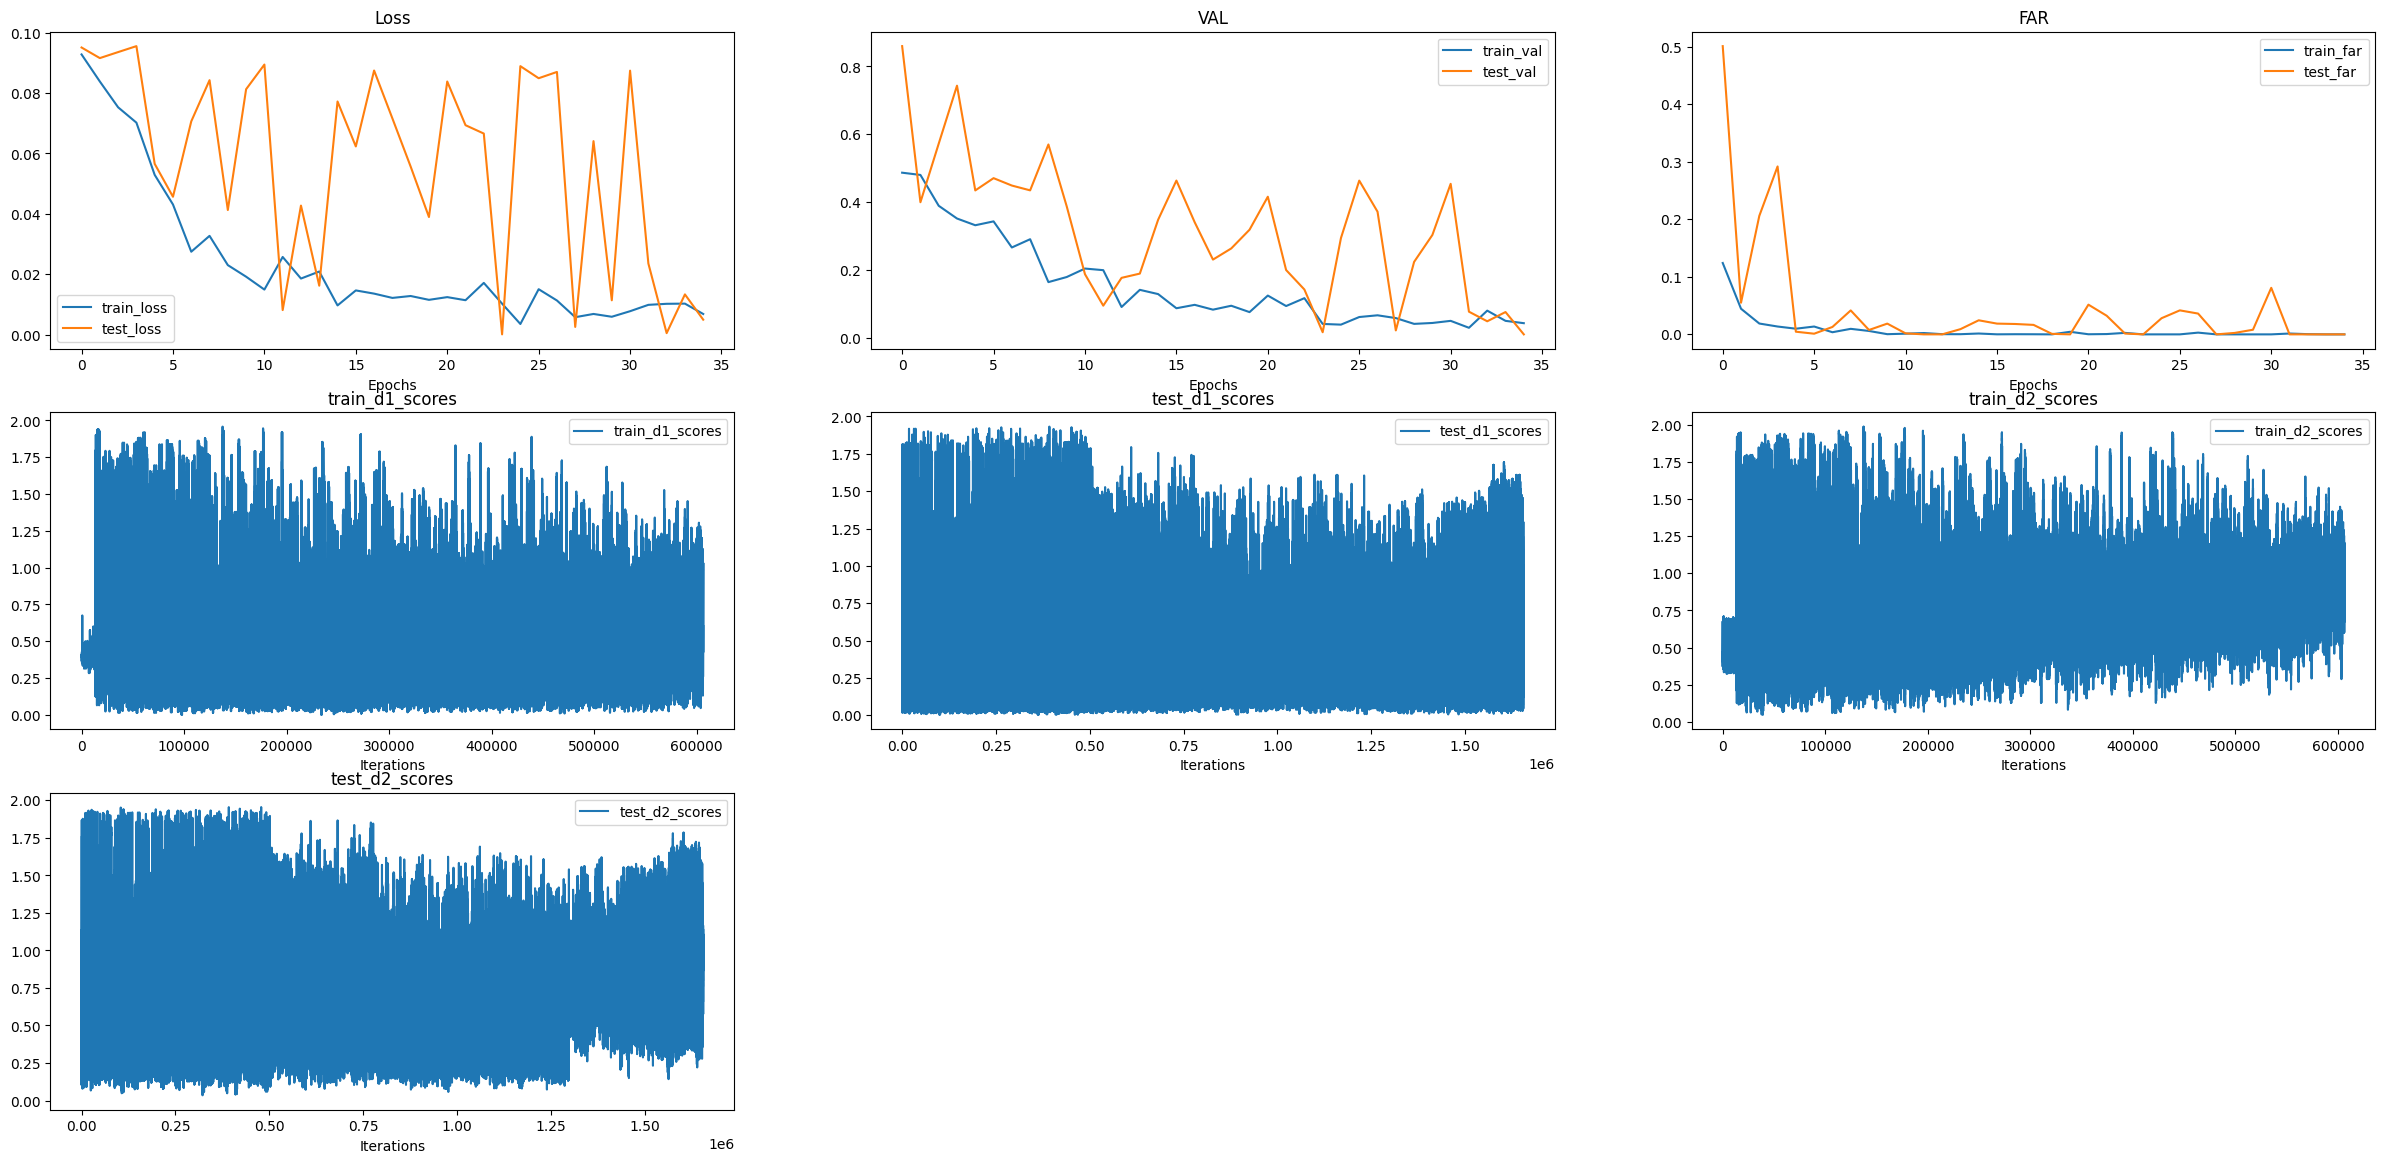

In [52]:
from datetime import date

#Create model directory path
MODEL_PATH=Path('models_cinthia')
MODEL_PATH.mkdir(parents=True,
                exist_ok=True)

DAY=date.today().strftime('%Y_%m_%d')

DAY_PATH=MODEL_PATH/DAY

DAY_PATH.mkdir(parents=True,
        exist_ok=True)

INTENTO_PATH=DAY_PATH/str(INTENTO)

INTENTO_PATH.mkdir(parents=True,
        exist_ok=True)

INTENTO+=1

#Create model save
MODEL_NAME=f'model_{HyperParameters.NUM_EPOCHS.value}_epochs.pth'
MODEL_SAVE_PATH=INTENTO_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(),
        f=MODEL_SAVE_PATH)

PATH_SETTINGS=INTENTO_PATH/'settings.txt'
with open(PATH_SETTINGS,'w') as f:
        for param in HyperParameters:
                row=f"{param.name} : {param.value} \n"
                f.writelines(row)


plot_loss_curves(results_model_1,dir=INTENTO_PATH/'metrics_graphic.png')



Text(0.5, 0, 'Iterations')

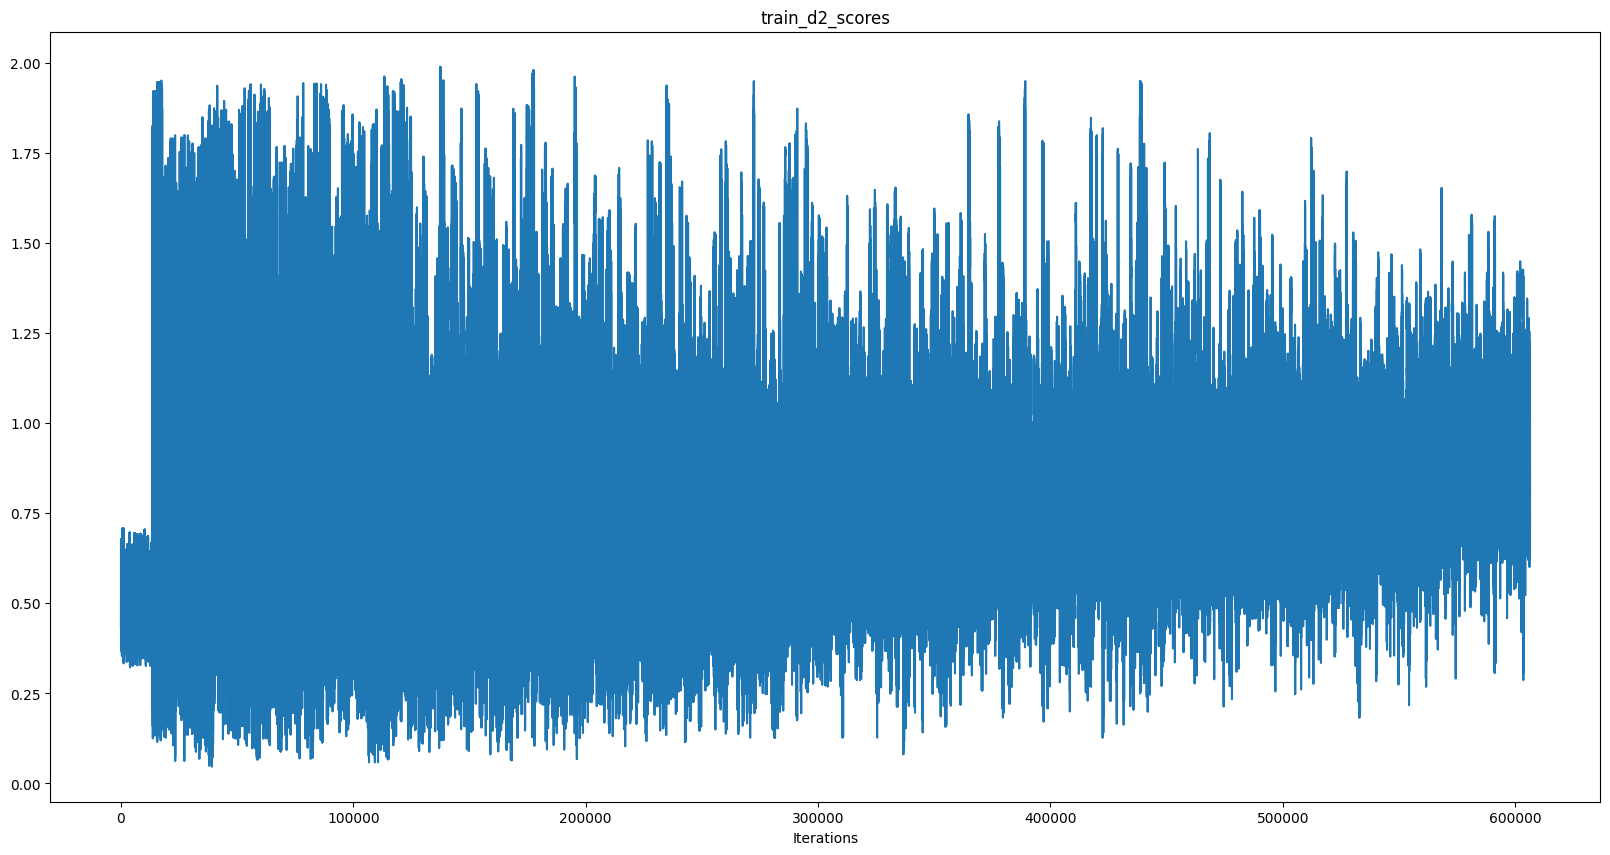

In [53]:
#Plot the FAR
field='train_d2_scores'
iterations_1=range(len(results_model_1[field]))

train_d1_scores=results_model_1[field]

plt.figure(figsize=(20,10))
plt.plot(iterations_1,train_d1_scores)
plt.title(field)
plt.xlabel("Iterations")


In [54]:
import numpy as np
import pandas as pd

df=pd.DataFrame(results_model_1[field],columns=[field])
#df.tail(20000).mean()

In [55]:
df=pd.DataFrame(results_model_1[field],columns=[field])
factor_div=round(len(df) / 35)

factor_div

total=35

for i in range(total):
    if i == (total - 1):
        mean=df.iloc[factor_div*(i):][field].mean()    
        print(f'{i+1} epoch: {mean}')
        break
    mean=df.iloc[factor_div*i:factor_div*(i+1)][field].mean()
    print(f'{i+1} epoch: {mean}')



1 epoch: 0.5140676067905946
2 epoch: 0.7003066459960102
3 epoch: 0.8331200777815582
4 epoch: 0.782928161308018
5 epoch: 0.7838888183482123
6 epoch: 0.8102976324011343
7 epoch: 0.8011448774256691
8 epoch: 0.7624484793786446
9 epoch: 0.8014000446620156
10 epoch: 0.7453030314678388
11 epoch: 0.749378410805575
12 epoch: 0.7762771394083122
13 epoch: 0.7426538903144051
14 epoch: 0.7406012788629992
15 epoch: 0.7363349672246065
16 epoch: 0.770608251944057
17 epoch: 0.7406298638274367
18 epoch: 0.8041229343256384
19 epoch: 0.7748100514607764
20 epoch: 0.7706343559348275
21 epoch: 0.7585908516474228
22 epoch: 0.7742208622101823
23 epoch: 0.7361506897817649
24 epoch: 0.773401412605393
25 epoch: 0.8029085636789186
26 epoch: 0.8043983875991249
27 epoch: 0.8016006965332096
28 epoch: 0.8205842171384732
29 epoch: 0.8258972855362653
30 epoch: 0.8642746147075403
31 epoch: 0.8416300609835133
32 epoch: 0.8487811570983235
33 epoch: 0.8759530646074069
34 epoch: 0.9013876746458315
35 epoch: 0.893530009715743